In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft
import tqdm

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [2]:
# mpl.use("pgf")  # to display graphs remove this line
mpl.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
line = 0.75

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
import multiprocessing as mp
import tqdm
from functools import partial

from specsens import util
from specsens import util_sim
from specsens import WirelessMicrophone
from specsens import WhiteGaussianNoise
from specsens import Stft
from specsens import WidebandEnergyDetector
from specsens import noise_est as noise_esti


def generation(f_sample, length_sec, itrs, noise_power, signal_power,
               noise_uncert, window, fft_len, sigs, num_bands,
               band_noise_est, cov_size, seeds):

    # create new signal objects
    wm = WirelessMicrophone(f_sample=f_sample, t_sec=length_sec, seed=seeds[0])
    wgn = WhiteGaussianNoise(f_sample=f_sample,
                             t_sec=length_sec,
                             seed=seeds[1])

    # local rng
    rng = np.random.default_rng(seeds[2])

    # calculate noise power with uncertainty
    gen_noise_power = rng.normal(loc=noise_power, scale=noise_uncert)

    # list of noise estimation errors
    errs_time = np.array([])
    errs_band = np.array([])
    errs_eig_avg = np.array([])
    errs_eig_hist = np.array([])
    errs_eig_kde = np.array([])
    errs_eig_mle = np.array([])

    # 'inner' interations loop
    for _ in range(itrs):

        sig = wm.soft(f_center=0., power=signal_power, dB=True)
        for i in range(-int(sigs*100000), 0, 50000):
            sig += wm.soft(f_center=i, power=signal_power, dB=True)
        for i in range(50000, int(sigs*100000+50000), 50000):
            sig += wm.soft(f_center=i, power=signal_power, dB=True)
        
        # generate noise
        noise = wgn.signal(power=gen_noise_power, dB=True)

        # create acutal signal
        both = sig + noise

        # time noise estimation
        est_time = util.dB_power(np.mean(np.abs(noise)**2.))

        # create a Short Time Fourier Transform object
        sft = Stft(n=fft_len, window=window)
        # use the stft to transform the signal into the frequency domain
        f, psd = sft.stft(both, f_sample, normalized=False, dB=False)
#         f, psd = sft.stft(noise, f_sample, normalized=False, dB=False)
        # create a Wideband Energy Detector object
        fed = WidebandEnergyDetector(num_bands=num_bands,
                                     f_sample=f_sample,
                                     fft_len=fft_len,
                                     freqs=f)
        # compute energy for all bands
        bands = fed.detect(psd)
        # in band noise estimation
        est_band = util.dB_power(bands[band_noise_est] / (fft_len / num_bands))

        # eigenvalue noise estimation
        est_eig_avg, est_eig_hist, est_eig_kde, est_eig_mle = noise_esti.estimate(
            both, int(f_sample * length_sec), l=cov_size)

        # calculate errors
        err_time = util.dB_rel_err(gen_noise_power, est_time)
        err_band = util.dB_rel_err(gen_noise_power, est_band)
        err_eig_avg = util.dB_rel_err(gen_noise_power, est_eig_avg)
        err_eig_hist = util.dB_rel_err(gen_noise_power, est_eig_hist)
        err_eig_kde = util.dB_rel_err(gen_noise_power, est_eig_kde)
        err_eig_mle = util.dB_rel_err(gen_noise_power, est_eig_mle)

        # append to errors list
        errs_time = np.append(errs_time, err_time)
        errs_band = np.append(errs_band, err_band)
        errs_eig_avg = np.append(errs_eig_avg, err_eig_avg)
        errs_eig_hist = np.append(errs_eig_hist, err_eig_hist)
        errs_eig_kde = np.append(errs_eig_kde, err_eig_kde)
        errs_eig_mle = np.append(errs_eig_mle, err_eig_mle)

    # calculate average error and return
    return np.mean(errs_time), np.mean(errs_band), np.mean(
        errs_eig_avg), np.mean(errs_eig_hist), np.mean(errs_eig_kde), np.mean(
            errs_eig_mle)


def estimation_comparison_sim(
        gens=50,  # generations, number of environments
        itrs=300,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=0.,  # in dB
        sigs=0,  # signals
        noise_power=0.,  # in dB
        length_sec=None,  # length of each section in seconds
        num_samples=None,  # number of samples
        noise_uncert=0.0,  # standard deviation of the noise normal distribution
        seed=None,  # random seed used for rng
        num_procs=None,  # number of processes to run in parallel
        window='box',  # window used with fft
        fft_len=1024,  # samples used for fft
        num_bands=1,  # total number of bands
        band_noise_est=None,  # band to use for noise estimation
        cov_size=50):

    # set number of processes used
    if num_procs is None:
        num_procs = mp.cpu_count()
    assert num_procs > 0, 'num_procs must be greater than 0'
    assert num_procs <= gens, 'num_procs must be less or equal to gens'

    # check and calculate length (in seconds and number of samples)
    if num_samples is not None:
        assert num_samples > 0., 'num_samples must be greater than 0'
        length_sec = num_samples / f_sample
    elif length_sec is not None:
        assert length_sec > 0., 'length_sec must be greater than 0'
        length_sec = length_sec
        num_samples = int(f_sample * length_sec)
    else:
        assert False, 'either num_samples or length_sec needed'

    print('---- Simulation parameters ----')
    print('Generations:    %d' % (gens))
    print('Iterations:     %d' % (itrs))
    print('Total iters:    %d' % (gens * itrs))
    print('Signal power:   %.2f dB' % (signal_power))
    print('Num sigs:       %d' % (sigs))
    print('Noise power:    %.2f dB' % (noise_power))
    print('Noise uncert:   %.2f dB' % (noise_uncert))
    print('SNR:            %.2f dB' % (signal_power - noise_power))
    print('Signal length:  %.6f s' % (length_sec))
    print('Signal samples: %d' % (num_samples))
    print('FFT length:     %d' % (fft_len))
    print('Num. of bands:  %d' % (num_bands))
    print('Band noise est: %d' % (band_noise_est))

    print('---- Running simulation ----')
    print('Using %d processes on %d cores' % (num_procs, mp.cpu_count()))

    # generate child seeds for wm and wgn
    seed_seq = np.random.SeedSequence(seed)
    seeds = list(
        zip(seed_seq.spawn(gens), seed_seq.spawn(gens), seed_seq.spawn(gens)))

    # prepare parallel execution
    p = mp.Pool(processes=num_procs)
    f = partial(generation, f_sample, length_sec, itrs, noise_power,
                signal_power, noise_uncert, window, fft_len, sigs,
                num_bands, band_noise_est, cov_size)

    # run simulation while showing progress bar
    res = list(tqdm.tqdm(p.imap(f, seeds), total=gens))

    # cleanup parallel execution
    p.close()
    p.join()

    # 'unwrap' res tuples
    errs_time = [r[0] for r in res]
    errs_band = [r[1] for r in res]
    errs_eig_avg = [r[2] for r in res]
    errs_eig_hist = [r[3] for r in res]
    errs_eig_kde = [r[4] for r in res]
    errs_eig_mle = [r[5] for r in res]

    err_time = np.mean(errs_time)
    err_band = np.mean(errs_band)
    err_eig_avg = np.mean(errs_eig_avg)
    err_eig_hist = np.mean(errs_eig_hist)
    err_eig_kde = np.mean(errs_eig_kde)
    err_eig_mle = np.mean(errs_eig_mle)

    print('---- Simulation stats ----')
    print('Err time:             %.4f dB' % (err_time))
    print('Err band:             %.4f dB' % (err_band))
    print('Err eigenval average: %.4f dB' % (err_eig_avg))
    print('Err eigenval hist:    %.4f dB' % (err_eig_hist))
    print('Err eigenval kde:     %.4f dB' % (err_eig_kde))
    print('Err eigenval mle:     %.4f dB' % (err_eig_mle))

    return err_time, err_band, err_eig_avg, err_eig_hist, err_eig_kde, err_eig_mle

gens=50
itrs=1

In [17]:
res_list_length = []
x_length = list(map(lambda x: 2**x, range(9, 20)))

for i in tqdm.tqdm(x_length):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=10.0,  # in dB
        length_sec=i/1e6,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=i,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=1,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=20)
    res_list_length.append(res)

  0%|          | 0/11 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.000512 s
Signal samples: 512
FFT length:     512
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



  9%|▉         | 1/11 [00:13<02:10, 13.01s/it]

---- Simulation stats ----
Err time:             -16.1922 dB
Err band:             -13.9249 dB
Err eigenval average: -15.4661 dB
Err eigenval hist:    -15.1499 dB
Err eigenval kde:     -13.5559 dB
Err eigenval mle:     -14.5728 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.001024 s
Signal samples: 1024
FFT length:     1024
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 18%|█▊        | 2/11 [00:25<01:56, 12.95s/it]

---- Simulation stats ----
Err time:             -17.2956 dB
Err band:             -14.9680 dB
Err eigenval average: -14.5442 dB
Err eigenval hist:    -15.7246 dB
Err eigenval kde:     -14.3494 dB
Err eigenval mle:     -15.0543 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.002048 s
Signal samples: 2048
FFT length:     2048
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 27%|██▋       | 3/11 [00:38<01:42, 12.82s/it]

---- Simulation stats ----
Err time:             -18.4986 dB
Err band:             -15.3105 dB
Err eigenval average: -15.2659 dB
Err eigenval hist:    -17.4673 dB
Err eigenval kde:     -15.4245 dB
Err eigenval mle:     -16.7661 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.004096 s
Signal samples: 4096
FFT length:     4096
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 36%|███▋      | 4/11 [00:51<01:29, 12.77s/it]

---- Simulation stats ----
Err time:             -21.3157 dB
Err band:             -16.8173 dB
Err eigenval average: -20.2576 dB
Err eigenval hist:    -18.5537 dB
Err eigenval kde:     -19.8074 dB
Err eigenval mle:     -18.9213 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 45%|████▌     | 5/11 [01:03<01:16, 12.79s/it]

---- Simulation stats ----
Err time:             -23.1290 dB
Err band:             -18.9309 dB
Err eigenval average: -19.9158 dB
Err eigenval hist:    -20.0342 dB
Err eigenval kde:     -20.9954 dB
Err eigenval mle:     -21.3135 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.016384 s
Signal samples: 16384
FFT length:     16384
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 55%|█████▍    | 6/11 [01:16<01:04, 12.86s/it]

---- Simulation stats ----
Err time:             -23.5085 dB
Err band:             -19.9552 dB
Err eigenval average: -22.5301 dB
Err eigenval hist:    -21.3676 dB
Err eigenval kde:     -22.1389 dB
Err eigenval mle:     -22.2845 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.032768 s
Signal samples: 32768
FFT length:     32768
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 64%|██████▎   | 7/11 [01:31<00:53, 13.34s/it]

---- Simulation stats ----
Err time:             -25.5148 dB
Err band:             -23.1350 dB
Err eigenval average: -23.8841 dB
Err eigenval hist:    -22.6895 dB
Err eigenval kde:     -23.5596 dB
Err eigenval mle:     -24.1897 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.065536 s
Signal samples: 65536
FFT length:     65536
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 73%|███████▎  | 8/11 [01:48<00:43, 14.40s/it]

---- Simulation stats ----
Err time:             -25.7582 dB
Err band:             -24.5338 dB
Err eigenval average: -24.6238 dB
Err eigenval hist:    -24.2538 dB
Err eigenval kde:     -26.0399 dB
Err eigenval mle:     -25.4466 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.131072 s
Signal samples: 131072
FFT length:     131072
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 82%|████████▏ | 9/11 [02:12<00:34, 17.48s/it]

---- Simulation stats ----
Err time:             -28.8080 dB
Err band:             -24.6810 dB
Err eigenval average: -25.6787 dB
Err eigenval hist:    -27.1383 dB
Err eigenval kde:     -26.8180 dB
Err eigenval mle:     -26.1026 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.262144 s
Signal samples: 262144
FFT length:     262144
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 91%|█████████ | 10/11 [02:45<00:21, 22.00s/it]

---- Simulation stats ----
Err time:             -29.6536 dB
Err band:             -27.2429 dB
Err eigenval average: -28.3474 dB
Err eigenval hist:    -27.0420 dB
Err eigenval kde:     -28.9020 dB
Err eigenval mle:     -28.6136 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.524288 s
Signal samples: 524288
FFT length:     524288
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 11/11 [03:36<00:00, 19.64s/it]

---- Simulation stats ----
Err time:             -30.7158 dB
Err band:             -27.3932 dB
Err eigenval average: -30.0905 dB
Err eigenval hist:    -28.8641 dB
Err eigenval kde:     -29.3082 dB
Err eigenval mle:     -30.5069 dB


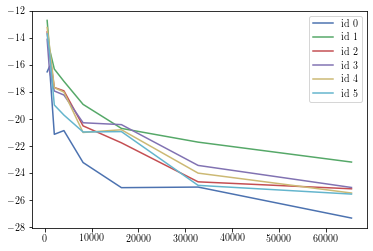

In [5]:
y = list(map(list, zip(*res_list_length)))

for i in range(6):
    plt.plot(x_length,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [6]:
res_list_sigs = []
x_sigs = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]

for i in tqdm.tqdm(x_sigs):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=10.0,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=i,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=20)
    res_list_sigs.append(res)

  0%|          | 0/10 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       0
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 10%|█         | 1/10 [00:14<02:08, 14.33s/it]

---- Simulation stats ----
Err time:             -21.9251 dB
Err band:             -20.1126 dB
Err eigenval average: -21.1191 dB
Err eigenval hist:    -20.3378 dB
Err eigenval kde:     -21.1684 dB
Err eigenval mle:     -21.0883 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       0
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 2/10 [00:27<01:52, 14.05s/it]

---- Simulation stats ----
Err time:             -22.3719 dB
Err band:             -18.5011 dB
Err eigenval average: -20.8964 dB
Err eigenval hist:    -19.4900 dB
Err eigenval kde:     -20.7307 dB
Err eigenval mle:     -21.1476 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 30%|███       | 3/10 [00:40<01:34, 13.53s/it]

---- Simulation stats ----
Err time:             -21.4171 dB
Err band:             -19.0732 dB
Err eigenval average: -21.2518 dB
Err eigenval hist:    -19.6705 dB
Err eigenval kde:     -20.4652 dB
Err eigenval mle:     -19.6121 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 4/10 [00:52<01:18, 13.07s/it]

---- Simulation stats ----
Err time:             -23.2622 dB
Err band:             -18.8844 dB
Err eigenval average: -18.6915 dB
Err eigenval hist:    -19.5691 dB
Err eigenval kde:     -18.9265 dB
Err eigenval mle:     -18.9030 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 50%|█████     | 5/10 [01:03<01:02, 12.45s/it]

---- Simulation stats ----
Err time:             -24.0709 dB
Err band:             -18.4569 dB
Err eigenval average: -20.0245 dB
Err eigenval hist:    -17.9246 dB
Err eigenval kde:     -18.5390 dB
Err eigenval mle:     -19.3703 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 6/10 [01:13<00:47, 11.83s/it]

---- Simulation stats ----
Err time:             -22.4318 dB
Err band:             -7.9683 dB
Err eigenval average: -18.9145 dB
Err eigenval hist:    -16.9531 dB
Err eigenval kde:     -18.0215 dB
Err eigenval mle:     -19.1753 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       3
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 70%|███████   | 7/10 [01:23<00:33, 11.20s/it]

---- Simulation stats ----
Err time:             -21.9759 dB
Err band:             -5.7101 dB
Err eigenval average: -17.7841 dB
Err eigenval hist:    -14.4628 dB
Err eigenval kde:     -15.7267 dB
Err eigenval mle:     -14.9318 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       3
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 8/10 [01:31<00:20, 10.45s/it]

---- Simulation stats ----
Err time:             -22.0462 dB
Err band:             -3.3367 dB
Err eigenval average: -17.8662 dB
Err eigenval hist:    -15.9414 dB
Err eigenval kde:     -17.4222 dB
Err eigenval mle:     -17.0608 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       4
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 90%|█████████ | 9/10 [01:41<00:10, 10.20s/it]

---- Simulation stats ----
Err time:             -23.4095 dB
Err band:             -3.6129 dB
Err eigenval average: -11.2759 dB
Err eigenval hist:    -13.5519 dB
Err eigenval kde:     -10.1629 dB
Err eigenval mle:     -14.1245 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       4
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 10/10 [01:51<00:00, 11.20s/it]

---- Simulation stats ----
Err time:             -22.6733 dB
Err band:             -4.0204 dB
Err eigenval average: -4.3875 dB
Err eigenval hist:    -4.4030 dB
Err eigenval kde:     -4.0431 dB
Err eigenval mle:     -5.3724 dB


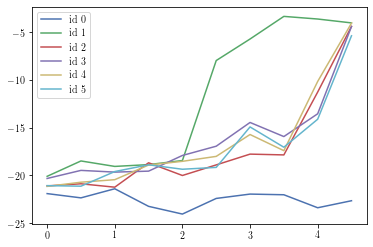

In [7]:
y = list(map(list, zip(*res_list_sigs)))

for i in range(6):
    plt.plot(x_sigs,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [8]:
res_list_snr = []
x_snr = range(-30, 20, 5)

for i in tqdm.tqdm(x_snr):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=i,  # in dB
        noise_power=0.0,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=1,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=20)
    res_list_snr.append(res)

  0%|          | 0/10 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   -30.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -30.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 10%|█         | 1/10 [00:14<02:11, 14.62s/it]

---- Simulation stats ----
Err time:             -21.5808 dB
Err band:             -19.2764 dB
Err eigenval average: -20.6729 dB
Err eigenval hist:    -19.9333 dB
Err eigenval kde:     -20.4391 dB
Err eigenval mle:     -20.9233 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   -25.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -25.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 2/10 [00:29<01:56, 14.62s/it]

---- Simulation stats ----
Err time:             -22.6936 dB
Err band:             -21.4320 dB
Err eigenval average: -20.9963 dB
Err eigenval hist:    -21.1969 dB
Err eigenval kde:     -20.9185 dB
Err eigenval mle:     -20.9332 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   -20.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -20.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 30%|███       | 3/10 [00:42<01:39, 14.27s/it]

---- Simulation stats ----
Err time:             -22.3670 dB
Err band:             -20.8859 dB
Err eigenval average: -20.8828 dB
Err eigenval hist:    -20.0697 dB
Err eigenval kde:     -20.9899 dB
Err eigenval mle:     -22.0139 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   -15.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -15.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 4/10 [00:55<01:23, 13.87s/it]

---- Simulation stats ----
Err time:             -22.0470 dB
Err band:             -19.7696 dB
Err eigenval average: -20.6896 dB
Err eigenval hist:    -20.1275 dB
Err eigenval kde:     -20.9054 dB
Err eigenval mle:     -20.6982 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   -10.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -10.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 50%|█████     | 5/10 [01:08<01:08, 13.61s/it]

---- Simulation stats ----
Err time:             -22.3310 dB
Err band:             -18.8086 dB
Err eigenval average: -21.7062 dB
Err eigenval hist:    -21.2897 dB
Err eigenval kde:     -20.9067 dB
Err eigenval mle:     -21.0096 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   -5.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            -5.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 6/10 [01:20<00:52, 13.18s/it]

---- Simulation stats ----
Err time:             -22.4754 dB
Err band:             -19.0920 dB
Err eigenval average: -21.7716 dB
Err eigenval hist:    -18.8544 dB
Err eigenval kde:     -20.1067 dB
Err eigenval mle:     -20.2547 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   0.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            0.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 70%|███████   | 7/10 [01:32<00:38, 12.76s/it]

---- Simulation stats ----
Err time:             -22.7931 dB
Err band:             -18.1206 dB
Err eigenval average: -21.2180 dB
Err eigenval hist:    -19.3434 dB
Err eigenval kde:     -20.4505 dB
Err eigenval mle:     -19.7182 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   5.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            5.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 8/10 [01:44<00:24, 12.44s/it]

---- Simulation stats ----
Err time:             -22.4575 dB
Err band:             -17.9160 dB
Err eigenval average: -20.5780 dB
Err eigenval hist:    -19.2698 dB
Err eigenval kde:     -20.3007 dB
Err eigenval mle:     -20.4967 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   10.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            10.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 90%|█████████ | 9/10 [01:55<00:12, 12.19s/it]

---- Simulation stats ----
Err time:             -21.9282 dB
Err band:             -18.2378 dB
Err eigenval average: -21.1869 dB
Err eigenval hist:    -19.0594 dB
Err eigenval kde:     -20.0766 dB
Err eigenval mle:     -20.0168 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   15.00 dB
Num sigs:       1
Noise power:    0.00 dB
Noise uncert:   10.00 dB
SNR:            15.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 10/10 [02:07<00:00, 12.72s/it]

---- Simulation stats ----
Err time:             -22.5441 dB
Err band:             -16.5426 dB
Err eigenval average: -21.5957 dB
Err eigenval hist:    -19.4421 dB
Err eigenval kde:     -22.1781 dB
Err eigenval mle:     -20.7825 dB


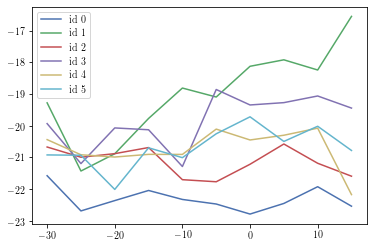

In [9]:
y = list(map(list, zip(*res_list_snr)))

for i in range(6):
    plt.plot(x_snr,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [10]:
res_list_cov1 = []
x_cov1 = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for i in tqdm.tqdm(x_cov1):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=i,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=1,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=i)
    res_list_cov1.append(res)

  0%|          | 0/10 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    5.00 dB
Noise uncert:   10.00 dB
SNR:            -4.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 10%|█         | 1/10 [00:06<01:01,  6.81s/it]

---- Simulation stats ----
Err time:             -22.8287 dB
Err band:             -19.3107 dB
Err eigenval average: -19.3584 dB
Err eigenval hist:    -19.2250 dB
Err eigenval kde:     -17.6134 dB
Err eigenval mle:     -20.3865 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 2/10 [00:15<00:59,  7.47s/it]

---- Simulation stats ----
Err time:             -22.2606 dB
Err band:             -18.3950 dB
Err eigenval average: -21.1244 dB
Err eigenval hist:    -20.2681 dB
Err eigenval kde:     -20.0826 dB
Err eigenval mle:     -20.0349 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    15.00 dB
Noise uncert:   10.00 dB
SNR:            -14.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 30%|███       | 3/10 [00:26<00:59,  8.56s/it]

---- Simulation stats ----
Err time:             -22.7016 dB
Err band:             -19.6031 dB
Err eigenval average: -21.2562 dB
Err eigenval hist:    -21.5558 dB
Err eigenval kde:     -21.9422 dB
Err eigenval mle:     -21.6444 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    20.00 dB
Noise uncert:   10.00 dB
SNR:            -19.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 4/10 [00:40<00:59,  9.99s/it]

---- Simulation stats ----
Err time:             -21.6397 dB
Err band:             -20.0959 dB
Err eigenval average: -20.4215 dB
Err eigenval hist:    -19.5939 dB
Err eigenval kde:     -20.5025 dB
Err eigenval mle:     -20.3117 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    25.00 dB
Noise uncert:   10.00 dB
SNR:            -24.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 50%|█████     | 5/10 [00:56<00:59, 11.83s/it]

---- Simulation stats ----
Err time:             -22.0783 dB
Err band:             -18.8839 dB
Err eigenval average: -20.3896 dB
Err eigenval hist:    -19.7486 dB
Err eigenval kde:     -20.2477 dB
Err eigenval mle:     -20.3944 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    30.00 dB
Noise uncert:   10.00 dB
SNR:            -29.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 6/10 [01:15<00:55, 13.94s/it]

---- Simulation stats ----
Err time:             -21.2373 dB
Err band:             -19.8455 dB
Err eigenval average: -19.7662 dB
Err eigenval hist:    -19.0326 dB
Err eigenval kde:     -20.8695 dB
Err eigenval mle:     -20.2173 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    35.00 dB
Noise uncert:   10.00 dB
SNR:            -34.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 70%|███████   | 7/10 [01:37<00:48, 16.29s/it]

---- Simulation stats ----
Err time:             -21.7906 dB
Err band:             -18.8950 dB
Err eigenval average: -20.1285 dB
Err eigenval hist:    -19.4881 dB
Err eigenval kde:     -20.6234 dB
Err eigenval mle:     -20.4371 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    40.00 dB
Noise uncert:   10.00 dB
SNR:            -39.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 8/10 [02:00<00:37, 18.59s/it]

---- Simulation stats ----
Err time:             -21.5283 dB
Err band:             -18.6364 dB
Err eigenval average: -21.3169 dB
Err eigenval hist:    -19.9441 dB
Err eigenval kde:     -21.2510 dB
Err eigenval mle:     -20.9658 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    45.00 dB
Noise uncert:   10.00 dB
SNR:            -44.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 90%|█████████ | 9/10 [02:27<00:20, 20.92s/it]

---- Simulation stats ----
Err time:             -22.4417 dB
Err band:             -19.2122 dB
Err eigenval average: -22.1803 dB
Err eigenval hist:    -21.4888 dB
Err eigenval kde:     -22.1043 dB
Err eigenval mle:     -22.5146 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       1
Noise power:    50.00 dB
Noise uncert:   10.00 dB
SNR:            -49.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 10/10 [02:56<00:00, 17.60s/it]

---- Simulation stats ----
Err time:             -23.6337 dB
Err band:             -18.9694 dB
Err eigenval average: -22.7050 dB
Err eigenval hist:    -21.2018 dB
Err eigenval kde:     -22.4433 dB
Err eigenval mle:     -21.0292 dB


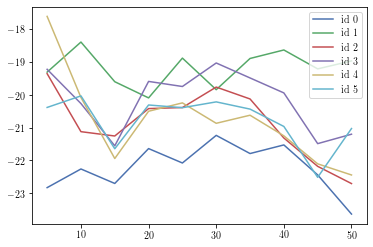

In [11]:
y = list(map(list, zip(*res_list_cov1)))

for i in range(6):
    plt.plot(x_cov1,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [12]:
res_list_cov2 = []
x_cov2 = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for i in tqdm.tqdm(x_cov2):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=i,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=2.5,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=i)
    res_list_cov2.append(res)

  0%|          | 0/10 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    5.00 dB
Noise uncert:   10.00 dB
SNR:            -4.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 10%|█         | 1/10 [00:07<01:03,  7.01s/it]

---- Simulation stats ----
Err time:             -22.2694 dB
Err band:             -4.6869 dB
Err eigenval average: -5.1788 dB
Err eigenval hist:    -7.1037 dB
Err eigenval kde:     -3.9080 dB
Err eigenval mle:     -11.3597 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    10.00 dB
Noise uncert:   10.00 dB
SNR:            -9.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 2/10 [00:14<00:57,  7.19s/it]

---- Simulation stats ----
Err time:             -21.5664 dB
Err band:             -7.4358 dB
Err eigenval average: -17.6575 dB
Err eigenval hist:    -16.8415 dB
Err eigenval kde:     -17.8032 dB
Err eigenval mle:     -17.0151 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    15.00 dB
Noise uncert:   10.00 dB
SNR:            -14.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 30%|███       | 3/10 [00:24<00:56,  8.07s/it]

---- Simulation stats ----
Err time:             -22.7208 dB
Err band:             -12.2011 dB
Err eigenval average: -16.7417 dB
Err eigenval hist:    -15.0798 dB
Err eigenval kde:     -16.6629 dB
Err eigenval mle:     -18.5322 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    20.00 dB
Noise uncert:   10.00 dB
SNR:            -19.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 4/10 [00:37<00:56,  9.37s/it]

---- Simulation stats ----
Err time:             -21.7211 dB
Err band:             -13.2643 dB
Err eigenval average: -16.9453 dB
Err eigenval hist:    -16.4538 dB
Err eigenval kde:     -16.6231 dB
Err eigenval mle:     -17.7605 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    25.00 dB
Noise uncert:   10.00 dB
SNR:            -24.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 50%|█████     | 5/10 [00:52<00:56, 11.24s/it]

---- Simulation stats ----
Err time:             -21.2568 dB
Err band:             -16.0185 dB
Err eigenval average: -17.5500 dB
Err eigenval hist:    -16.8872 dB
Err eigenval kde:     -16.6314 dB
Err eigenval mle:     -17.8535 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    30.00 dB
Noise uncert:   10.00 dB
SNR:            -29.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 6/10 [01:11<00:53, 13.45s/it]

---- Simulation stats ----
Err time:             -21.6673 dB
Err band:             -18.2720 dB
Err eigenval average: -17.9842 dB
Err eigenval hist:    -17.3965 dB
Err eigenval kde:     -17.2694 dB
Err eigenval mle:     -18.8645 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    35.00 dB
Noise uncert:   10.00 dB
SNR:            -34.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 70%|███████   | 7/10 [01:32<00:47, 15.86s/it]

---- Simulation stats ----
Err time:             -22.9414 dB
Err band:             -18.5145 dB
Err eigenval average: -22.0208 dB
Err eigenval hist:    -19.6564 dB
Err eigenval kde:     -21.8433 dB
Err eigenval mle:     -21.2250 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    40.00 dB
Noise uncert:   10.00 dB
SNR:            -39.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 8/10 [01:56<00:36, 18.26s/it]

---- Simulation stats ----
Err time:             -22.1496 dB
Err band:             -18.7965 dB
Err eigenval average: -22.0358 dB
Err eigenval hist:    -20.2956 dB
Err eigenval kde:     -21.1828 dB
Err eigenval mle:     -21.3859 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    45.00 dB
Noise uncert:   10.00 dB
SNR:            -44.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 90%|█████████ | 9/10 [02:23<00:20, 20.68s/it]

---- Simulation stats ----
Err time:             -21.2535 dB
Err band:             -19.6196 dB
Err eigenval average: -21.0643 dB
Err eigenval hist:    -20.4323 dB
Err eigenval kde:     -21.4981 dB
Err eigenval mle:     -21.4591 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       2
Noise power:    50.00 dB
Noise uncert:   10.00 dB
SNR:            -49.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 10/10 [02:51<00:00, 17.17s/it]

---- Simulation stats ----
Err time:             -23.4023 dB
Err band:             -19.9697 dB
Err eigenval average: -23.4325 dB
Err eigenval hist:    -21.7831 dB
Err eigenval kde:     -22.4333 dB
Err eigenval mle:     -22.1698 dB


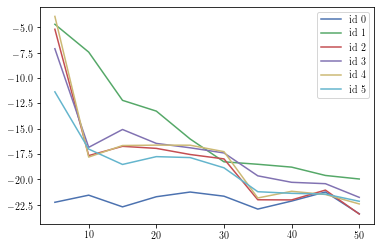

In [13]:
y = list(map(list, zip(*res_list_cov2)))

for i in range(6):
    plt.plot(x_cov2,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

In [14]:
res_list_cov3 = []
x_cov3 = [20, 40, 60, 80, 100]

for i in tqdm.tqdm(x_cov3):
    res = estimation_comparison_sim(
        gens=gens,  # generations, number of environments
        itrs=itrs,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=1.0,  # in dB
        noise_power=i,  # in dB
        length_sec=0.008192,  # length of each sample in seconds
        noise_uncert=
        10.0,  # standard deviation of the noise normal distribution in dB
        num_procs=None,  # number of processes to run in parallel
        seed=None,  # set seed for reproducibility
        window='box',  # window used with fft
        fft_len=8192,  # samples used for fft
        num_bands=4,  # total number of bands
        sigs=4,  # signal center frequency
        band_noise_est=3,  # band to use for noise estimation
        cov_size=i)
    res_list_cov3.append(res)

  0%|          | 0/5 [00:00<?, ?it/s]

---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       4
Noise power:    20.00 dB
Noise uncert:   10.00 dB
SNR:            -19.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 20%|██        | 1/5 [00:11<00:46, 11.53s/it]

---- Simulation stats ----
Err time:             -22.1935 dB
Err band:             -8.5413 dB
Err eigenval average: -12.9882 dB
Err eigenval hist:    -13.9094 dB
Err eigenval kde:     -12.2590 dB
Err eigenval mle:     -14.0167 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       4
Noise power:    40.00 dB
Noise uncert:   10.00 dB
SNR:            -39.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 40%|████      | 2/5 [00:36<00:46, 15.51s/it]

---- Simulation stats ----
Err time:             -21.7499 dB
Err band:             -18.0878 dB
Err eigenval average: -19.8088 dB
Err eigenval hist:    -19.2717 dB
Err eigenval kde:     -18.8666 dB
Err eigenval mle:     -19.4189 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       4
Noise power:    60.00 dB
Noise uncert:   10.00 dB
SNR:            -59.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 60%|██████    | 3/5 [01:11<00:43, 21.54s/it]

---- Simulation stats ----
Err time:             -21.4697 dB
Err band:             -19.1867 dB
Err eigenval average: -21.4214 dB
Err eigenval hist:    -20.0759 dB
Err eigenval kde:     -20.9810 dB
Err eigenval mle:     -20.9685 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       4
Noise power:    80.00 dB
Noise uncert:   10.00 dB
SNR:            -79.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



 80%|████████  | 4/5 [02:01<00:29, 29.89s/it]

---- Simulation stats ----
Err time:             -22.8406 dB
Err band:             -20.0459 dB
Err eigenval average: -22.8022 dB
Err eigenval hist:    -20.7927 dB
Err eigenval kde:     -22.0954 dB
Err eigenval mle:     -19.3803 dB
---- Simulation parameters ----
Generations:    50
Iterations:     1
Total iters:    50
Signal power:   1.00 dB
Num sigs:       4
Noise power:    100.00 dB
Noise uncert:   10.00 dB
SNR:            -99.00 dB
Signal length:  0.008192 s
Signal samples: 8192
FFT length:     8192
Num. of bands:  4
Band noise est: 3
---- Running simulation ----
Using 8 processes on 8 cores



100%|██████████| 5/5 [02:56<00:00, 35.31s/it]

---- Simulation stats ----
Err time:             -22.2337 dB
Err band:             -20.7560 dB
Err eigenval average: -22.4946 dB
Err eigenval hist:    -20.7672 dB
Err eigenval kde:     -21.9654 dB
Err eigenval mle:     -19.3278 dB


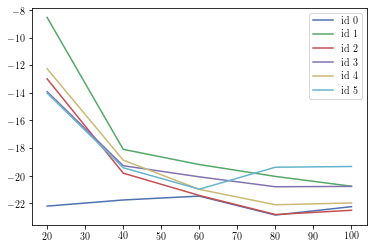

In [15]:
y = list(map(list, zip(*res_list_cov3)))

for i in range(6):
    plt.plot(x_cov3,y[i],label = 'id %s'%i)
plt.legend()
plt.show()

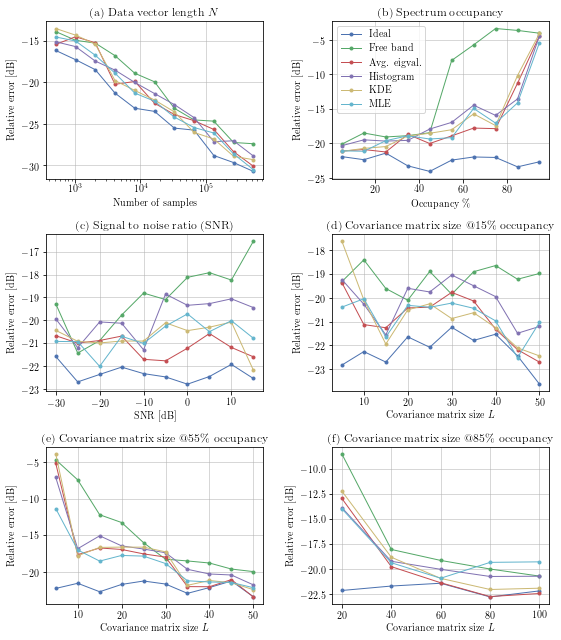

In [19]:
types = [r'Ideal', r'Free band', r'Avg. eigval.', r'Histogram', r'KDE', r'MLE']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 9))

y = list(map(list, zip(*res_list_length)))
for i in range(6):
    axs[0, 0].plot(x_length, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[0, 0].set_xlabel(r'Number of samples')
axs[0, 0].set_ylabel(r'Relative error [dB]')
axs[0, 0].set_title(r'(a) Data vector length $N$')
axs[0, 0].set_xscale('log')
axs[0, 0].grid(linewidth=0.5)

x_special = list(map(lambda x: round((x/5+0.05)*100, 2), x_sigs))
y = list(map(list, zip(*res_list_sigs)))
for i in range(6):
    axs[0, 1].plot(x_special, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[0, 1].set_xlabel(r'Occupancy \%')
axs[0, 1].set_ylabel(r'Relative error [dB]')
axs[0, 1].set_title(r'(b) Spectrum occupancy')
axs[0, 1].legend(loc=0)
axs[0, 1].grid(linewidth=0.5)

y = list(map(list, zip(*res_list_snr)))
for i in range(6):
    axs[1, 0].plot(x_snr, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[1, 0].set_xlabel(r'SNR [dB]')
axs[1, 0].set_ylabel(r'Relative error [dB]')
axs[1, 0].set_title(r'(c) Signal to noise ratio (SNR)')
axs[1, 0].grid(linewidth=0.5)

y = list(map(list, zip(*res_list_cov1)))
for i in range(6):
    axs[1, 1].plot(x_cov1, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[1, 1].set_xlabel(r'Covariance matrix size $L$')
axs[1, 1].set_ylabel(r'Relative error [dB]')
axs[1, 1].set_title(r'(d) Covariance matrix size $@15\%$ occupancy')
axs[1, 1].grid(linewidth=0.5)

y = list(map(list, zip(*res_list_cov2)))
for i in range(6):
    axs[2, 0].plot(x_cov2, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[2, 0].set_xlabel(r'Covariance matrix size $L$')
axs[2, 0].set_ylabel(r'Relative error [dB]')
axs[2, 0].set_title(r'(e) Covariance matrix size $@55\%$ occupancy')
axs[2, 0].grid(linewidth=0.5)

y = list(map(list, zip(*res_list_cov3)))
for i in range(6):
    axs[2, 1].plot(x_cov3, y[i], '.-', linewidth=1, label=types[i], aa=True)
axs[2, 1].set_xlabel(r'Covariance matrix size $L$')
axs[2, 1].set_ylabel(r'Relative error [dB]')
axs[2, 1].set_title(r'(f) Covariance matrix size $@85\%$ occupancy')
axs[2, 1].grid(linewidth=0.5)

plt.tight_layout()
plt.savefig('out/chap5/noise_estimation_comparison.pdf')